# R-VGA for logistic regression

$$
\begin{aligned}
    \mu_t &= \mu_{t-1} + P_{t-1}\left( y_t - \mathbb{E}\left[\sigma(\theta^\intercal{\bf x}_t\right] \right){\bf x}_t\\
    P_{t}^{-1} &= P_{t-1} - \mathbb{E}\left[\sigma'\left(\theta^\intercal {\bf x}_t\right)\right]
\end{aligned}
$$

In [174]:
import jax
import chex
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [110]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [111]:
mu1 = jnp.array([1.0, -1.0])
mu2 = -mu1

d = len(mu1)

In [175]:
@chex.dataclass
class Params:
    mean: jnp.DeviceArray
    cov: jnp.DeviceArray

In [140]:
key = jax.random.PRNGKey(314)
key_cov, key_data, key_choice = jax.random.split(key, 3)

In [141]:
c = 2.0
n_samp = 100

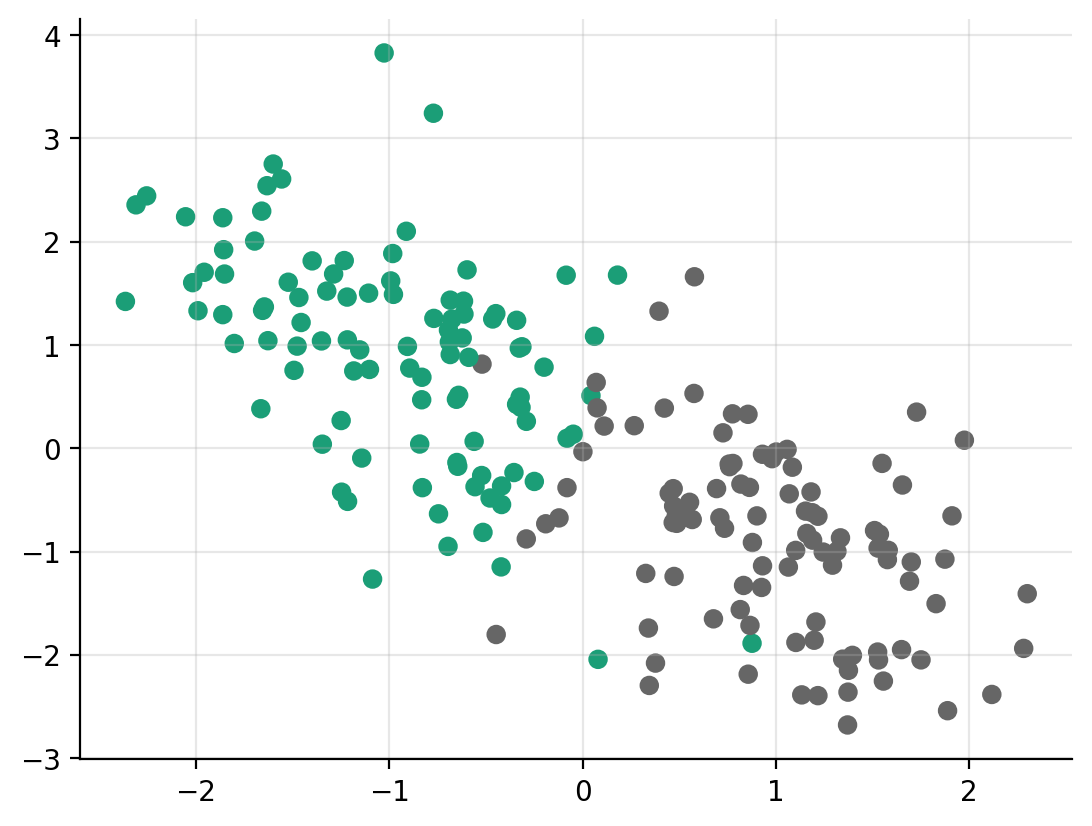

In [142]:
M = jax.random.orthogonal(key_cov, 2)
cov_diag = 1 / jnp.arange(1, d + 1) ** c
cov = jnp.einsum("ji,j,jk->ik", M, cov_diag, M, precision="highest")


X = jax.random.multivariate_normal(key_data, mean=jnp.zeros(d), cov=cov, shape=(2 * n_samp,))

X = X.at[:n_samp].set(X[:n_samp] + mu1)
X = X.at[n_samp:].set(X[n_samp:] + mu2)
y = jnp.append(jnp.ones(n_samp), jnp.zeros(n_samp))

choice = jax.random.choice(key_choice, 2 * n_samp, replace=False, shape=(2 * n_samp,))

X = X[choice]
y = y[choice]


plt.scatter(*X.T, c=y, cmap="Dark2")
plt.grid(alpha=0.3)

In [143]:
sigma2 = 1.0
mu0 = jnp.zeros(d)
cov0 = sigma2 * jnp.eye(d)
q0 = distrax.Normal(mu0, cov0)

In [ ]:
q0.sample()

In [144]:
n_samples = 100

In [166]:
@jax.jit
def expected_sigmoid(key, x, mu, cov):
    samples_theta = distrax.MultivariateNormalFullCovariance(mu, cov).sample(seed=key, sample_shape=(n_samples))
    yout = jnp.einsum("sm,m->s", samples_theta, x)
    yout = jax.nn.sigmoid(yout)
    
    return yout.mean()

In [170]:
@jax.jit
def expected_dsigmoid(key, x, mu, cov):
    samples_theta = distrax.MultivariateNormalFullCovariance(mu, cov).sample(seed=key, sample_shape=(n_samples))
    yout = jnp.einsum("sm,m->s", samples_theta, x)
    
    yout = jax.nn.sigmoid(yout)
    yout = yout * (1 - yout)
    
    return yout.mean()

In [171]:
expected_sigmoid(key, X[0], mu0, cov0)

Array(0.49823347, dtype=float32)

In [172]:
expected_dsigmoid(key, X[0], mu0, cov0)

Array(0.14250451, dtype=float32)

In [ ]:
def rvga_step(params, data):
    x, y = data
    esigma = ...